## <p style="color:red;text-align:center">**News Classifier**</p>

### <p style="text-align:center">**ML Pipeline with Sentence Transformers, ChromaDB & Airflow**</p>

Ce projet vise à construire un pipeline complet de classification de textes permettant de catégoriser automatiquement des articles d’actualité dans 4 classes :

- World
- Sports
- Business
- Sci/Tech

Le pipeline utilise des techniques NLP avancées, des embeddings vectoriels, une base de données vectorielle et une orchestration via Apache Airflow.

<br>

### <span style="color:green">**Entraînement & Évaluation :**</span>

#### <span style="color:orange">**1. Charger les Données :**</span>

##### **1.1. Etablir la Connexion avec ChromaDB :**

In [1]:
import chromadb
from chromadb.config import Settings

client = chromadb.PersistentClient(path="../chroma_db")

collections = client.list_collections()

print("Collections Disponibles :")

for col in collections:
    print(f"- {col.name}")

Collections Disponibles :
- test_news
- train_news


##### **1.2. Récupèrer les Collections :**

In [2]:
train_collection = client.get_collection(name=collections[1].name)
test_collection = client.get_collection(name=collections[0].name)

train_data = train_collection.get(include=['embeddings','metadatas'])
test_data = test_collection.get(include=['embeddings','metadatas'])

#### <span style="color:orange">**2. Séparer `X_train`, `y_train`, `X_test`, `y_test` :**</span>

In [3]:
import numpy as np

X_train = np.array(train_data['embeddings'])
X_test = np.array(test_data['embeddings'])

y_train = np.array([data['label'] for data in train_data['metadatas']])
y_test = np.array([data['label'] for data in test_data['metadatas']])

print(f"- Dimensions X_train : {X_train.shape}")
print(f"- Dimensions y_train : {y_train.shape}")
print(f"- Dimensions X_test  : {X_test.shape}")
print(f"- Dimensions y_test  : {y_test.shape}")

- Dimensions X_train : (120000, 384)
- Dimensions y_train : (120000,)
- Dimensions X_test  : (7600, 384)
- Dimensions y_test  : (7600,)


In [4]:
print("\n- 5 Premiers Labels Train :", y_train[:5])

print("\n- 5 Premiers Labels Test :", y_test[:5])


- 5 Premiers Labels Train : [2 2 2 2 2]

- 5 Premiers Labels Test : [2 3 3 3 3]


#### <span style="color:orange;">**3. Définition des Modèles ML à Entraîner :**</span>

	TRAITEMENT DU MODÈLE : Logistic Regression

- Entraînement...

- Accuracy  : 0.8847
- AUC Score (OvR) : 0.9738

- Rapport de Classification  : ---------
              precision    recall  f1-score   support

       World       0.90      0.89      0.89      1900
      Sports       0.95      0.96      0.95      1900
    Business       0.83      0.84      0.84      1900
    Sci/Tech       0.86      0.85      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


- Matrices de Confusion : ---------


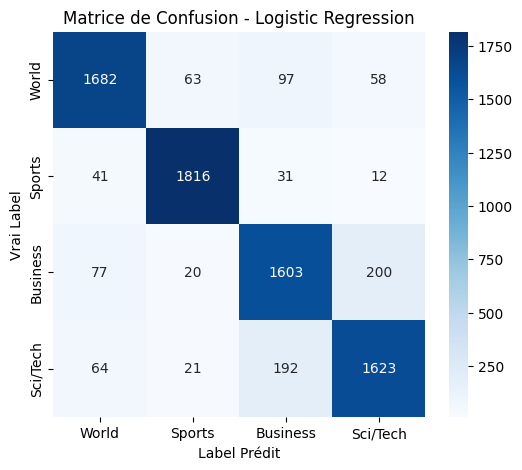


- Courbes ROC : ---------


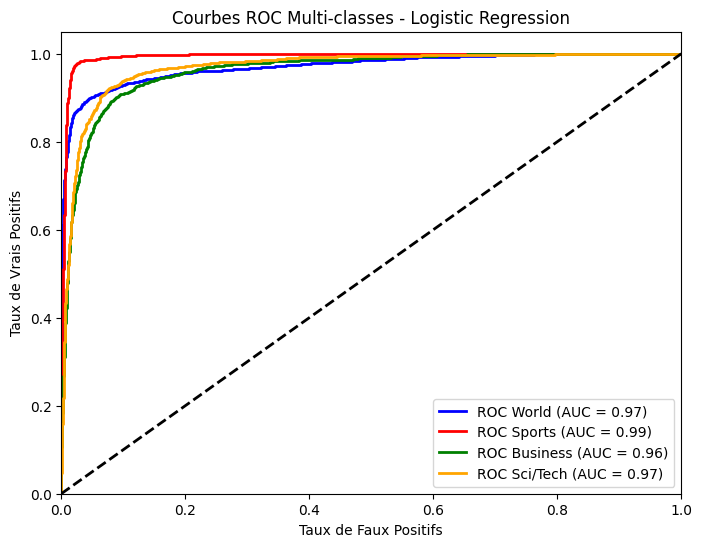

Génération de la courbe d'apprentissage (patientez)...


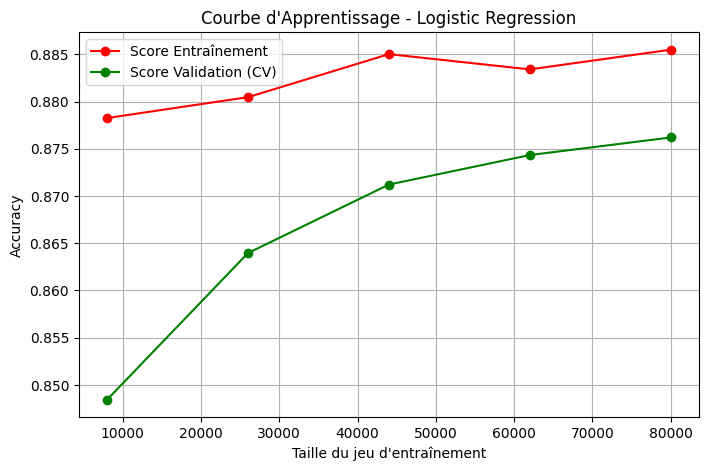




	TRAITEMENT DU MODÈLE : Linear SVC (Calibrated)

- Entraînement...

- Accuracy  : 0.8834
- AUC Score (OvR) : 0.9718

- Rapport de Classification  : ---------
              precision    recall  f1-score   support

       World       0.90      0.88      0.89      1900
      Sports       0.95      0.96      0.95      1900
    Business       0.83      0.84      0.83      1900
    Sci/Tech       0.86      0.85      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


- Matrices de Confusion : ---------


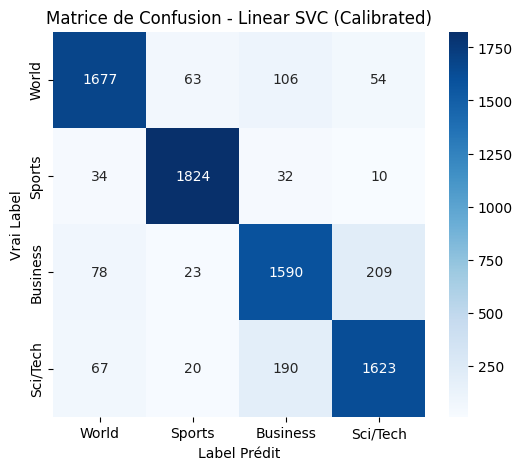


- Courbes ROC : ---------


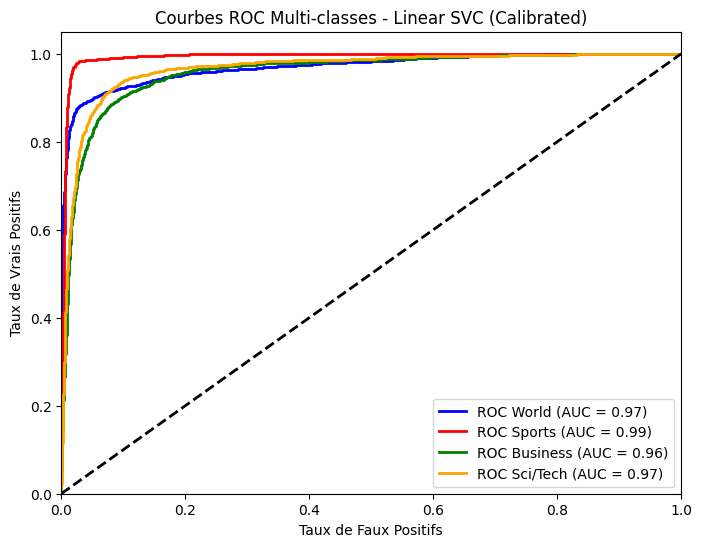

Génération de la courbe d'apprentissage (patientez)...


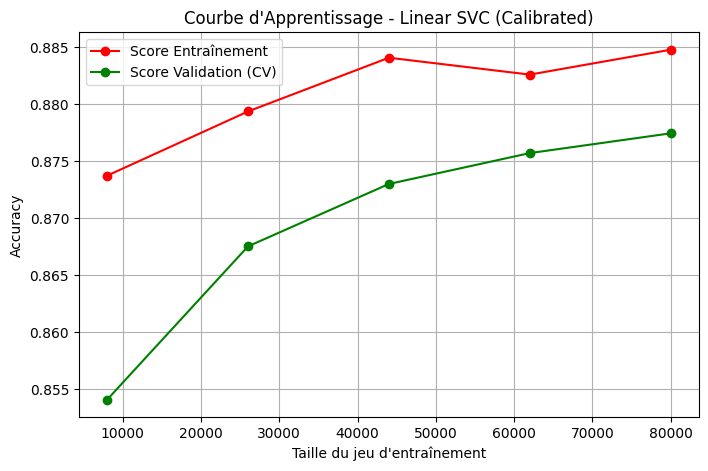




	TRAITEMENT DU MODÈLE : Random Forest

- Entraînement...

- Accuracy  : 0.8799
- AUC Score (OvR) : 0.9709

- Rapport de Classification  : ---------
              precision    recall  f1-score   support

       World       0.90      0.88      0.89      1900
      Sports       0.93      0.95      0.94      1900
    Business       0.83      0.84      0.84      1900
    Sci/Tech       0.86      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


- Matrices de Confusion : ---------


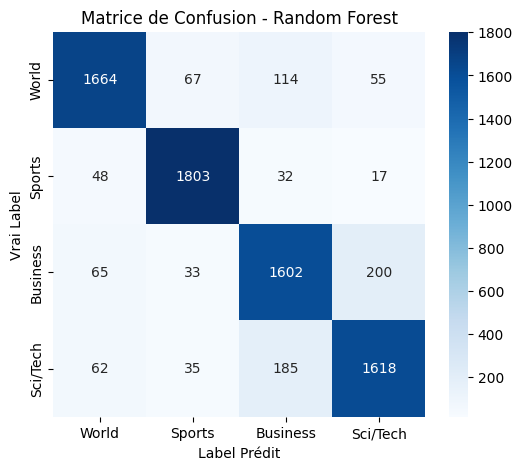


- Courbes ROC : ---------


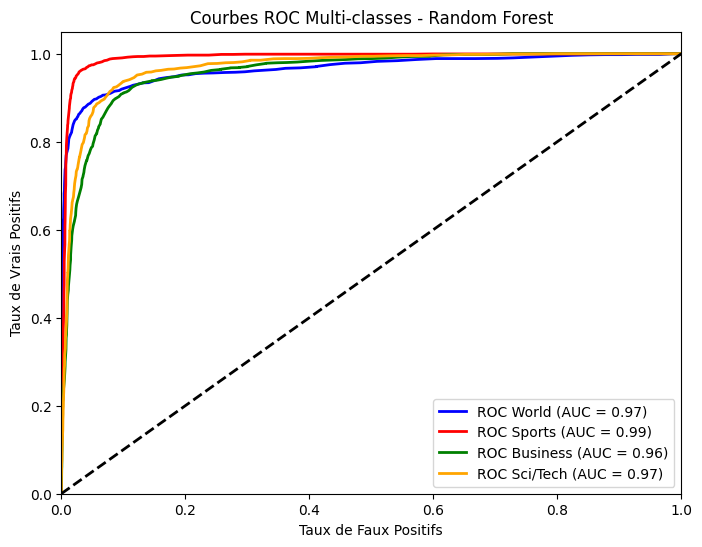

Génération de la courbe d'apprentissage (patientez)...


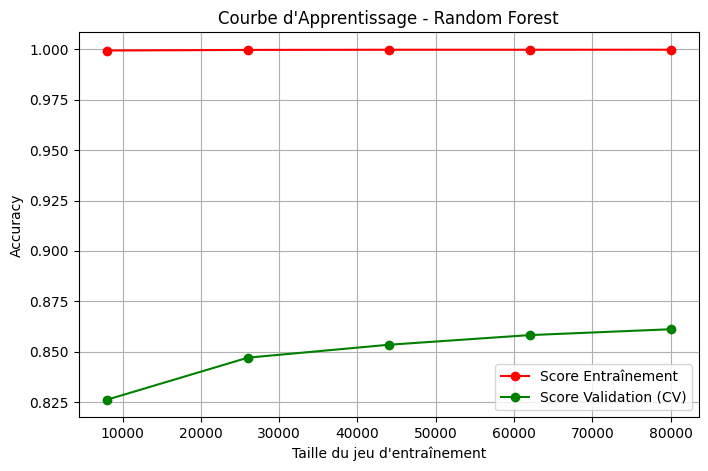

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from utils.functions import plot_confusion_matrix, plot_multiclass_roc, plot_learning_curve_graph
from sklearn.ensemble import RandomForestClassifier


# Noms des classes
target_names = ["World", "Sports", "Business", "Sci/Tech"]
n_classes = len(target_names)

# Binarisation des labels pour le calcul ROC (Multi-classe)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])


models = {
    "Logistic Regression": LogisticRegression(
        C=1, 
        solver='saga', 
        # multi_class='multinomial', 
        max_iter=1000
    ),
    "Linear SVC (Calibrated)": CalibratedClassifierCV(
        estimator=LinearSVC(C=0.1, penalty='l2', dual=False, max_iter=2000),
        method='sigmoid'    # Permet d'avoir predict_proba pour l'AUC
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        n_jobs=-1,
        random_state=42
    )
}



for name, model in models.items():
    print("="*60)
    print(f"\tTRAITEMENT DU MODÈLE : {name}")
    print("="*60)
    
    # A. Entraînement
    print("\n- Entraînement...")
    model.fit(X_train, y_train)
    
    # B. Prédictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) # Nécessaire pour ROC/AUC
    
    # C. Métriques Texte
    acc = accuracy_score(y_test, y_pred)
    auc_global = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    
    print(f"\n- Accuracy  : {acc:.4f}")
    print(f"- AUC Score (OvR) : {auc_global:.4f}")
    print("\n- Rapport de Classification  : ---------")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    print("\n- Matrices de Confusion : ---------")
    plot_confusion_matrix(y_test, y_pred, name, target_names)
    
    print("\n- Courbes ROC : ---------")
    plot_multiclass_roc(y_test_bin, y_prob, name, n_classes, target_names)
    
    print("Génération de la courbe d'apprentissage (patientez)...")
    plot_learning_curve_graph(model, X_train, y_train, name)
    
    print("\n\n")
    

#### <span style="color:orange;">**4. Définition du Modèles DL à Entraîner :**</span>

	TRAITEMENT DU MODÈLE : MLP Classifier (Réseaux Neurons) 

- Entraînement...

- Accuracy  : 0.9067
- AUC Score (OvR) : 0.9837

- Rapport de Classification  : ---------
              precision    recall  f1-score   support

       World       0.93      0.90      0.91      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.88      0.86      0.87      1900
    Sci/Tech       0.87      0.89      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


- Matrices de Confusion : ---------


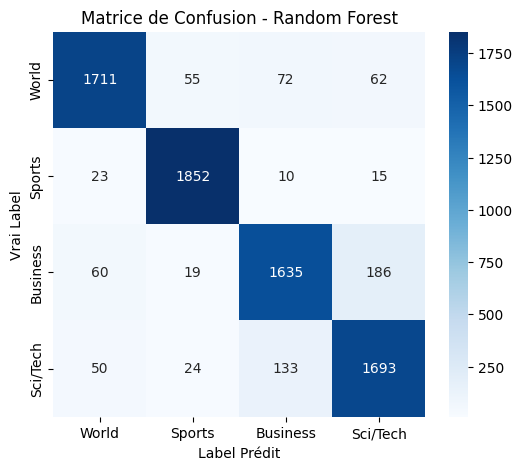


- Courbes ROC : ---------


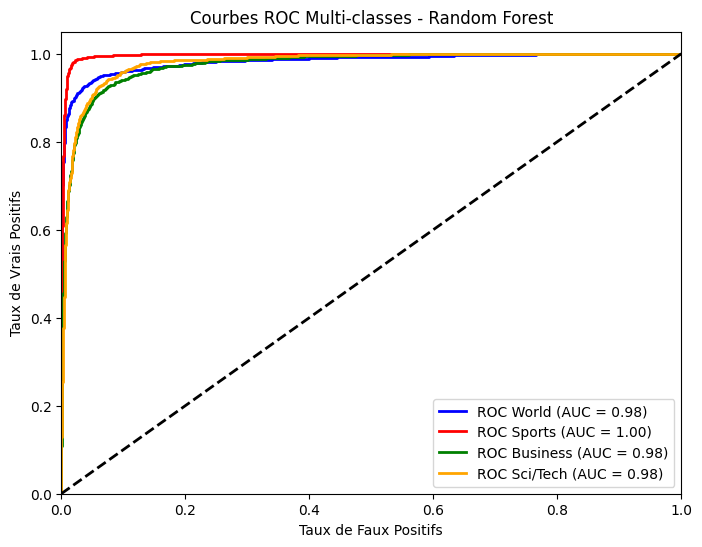

Génération de la courbe d'apprentissage (patientez)...


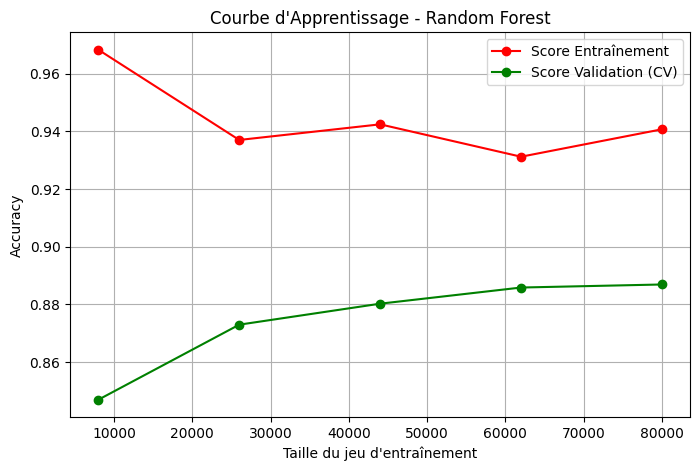

In [7]:
from sklearn.neural_network import MLPClassifier


mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64), 
    activation='relu', 
    solver='adam', 
    alpha=0.0005, 
    batch_size='auto', 
    learning_rate='adaptive', 
    max_iter=1000, 
    early_stopping=True, 
    n_iter_no_change=20, 
    random_state=42
)


print("="*60)
print("\tTRAITEMENT DU MODÈLE : MLP Classifier (Réseaux Neurons) ")
print("="*60)

print("\n- Entraînement...")
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
y_prob = mlp_model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
auc_global = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

print(f"\n- Accuracy  : {acc:.4f}")
print(f"- AUC Score (OvR) : {auc_global:.4f}")
print("\n- Rapport de Classification  : ---------")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n- Matrices de Confusion : ---------")
plot_confusion_matrix(y_test, y_pred, name, target_names)

print("\n- Courbes ROC : ---------")
plot_multiclass_roc(y_test_bin, y_prob, name, n_classes, target_names)

print("Génération de la courbe d'apprentissage (patientez)...")
plot_learning_curve_graph(mlp_model, X_train, y_train, name)

#### <span style="color:orange;">**5. Sauvegarder le Meilleur Modèle :**</span>

In [8]:
import joblib

joblib.dump(mlp_model, "../models/model.pkl")

print("Modèle Sauvegardé avec Succès !")

Modèle Sauvegardé avec Succès !
